In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import re
from scipy.optimize import curve_fit


In [80]:
def load_file(filenm):
    """
    Load xvg - file and return a pandas dataframe. 
    """
    data = []
    with open(filenm) as f:
        for line in f:
            #If line starts with @ or #, skip
            if line.startswith(('#', '@')):
                continue
            data.append([float(x) for x in re.split(r'\s+', line.strip())])
    return pd.DataFrame(data, columns=['time', 'value'])

In [81]:
def plot_variable_vs_reference(df, ref, color='blue', name=None):
    """
    Plots reference distribution as normalised histogram, and variable as kde-plot.
    Also shows the value of the variable used in the simulation by a red line.
    """
    #sns.histplot(ref.value, stat='density', label='AA')
    sns.kdeplot(ref.value, label='AA', color=color, alpha=0.5)
    #extract current y limits
    ylim = plt.ylim()
    sns.kdeplot(df.value,label='CG', color=color, ls='--', alpha=0.5)
    plt.ylim(ylim)
    #plt.plot([used_var, used_var], [ymin, ymax], color='red', label='Used value', ls='--', lw=2)
    plt.legend()
    plt.title(name)

In [82]:
def get_var_value(version):
    ITP_PATH = f"{version}/CG_*.itp"

    bonds = []
    angles = []
    dihedrals = []
    bcheck, acheck, dcheck = False, False, False

    with open(glob.glob(ITP_PATH)[0]) as f:
        for line in f:
            if line.startswith(';'):
                continue
            if line.startswith('[ bonds ]') or line.startswith('[ constraints ]'):
                bcheck = True
                continue
            if line.startswith('[ angles ]'):
                bcheck = False
                acheck = True
                continue
            if line.startswith('[ dihedrals ]'):
                acheck = False
                dcheck = True
                continue
            if line.startswith('['):
                bcheck, acheck, dcheck = False, False, False
                continue
            if len(re.split(r'\s+', line.strip())) < 2:
                continue
            if bcheck:
                bonds.append(float(re.split(r'\s+', line.strip())[3]))
            if acheck:
                angles.append(float(re.split(r'\s+', line.strip())[4]))
            if dcheck:
                dihedrals.append(float(re.split(r'\s+', line.strip())[5]))
    return bonds, angles, dihedrals

Versions CG_motor2m-R  and CG_motorb-R are the models used in production. v3x are models that attempt to improve the position of the methyle group, but it doesnt lead to any improvement.

In [83]:
version = "CG_motor2m-R" 
bonds, angles, dihedrals = get_var_value(version)
var_map = {'bonds': bonds, 'angles': angles, 'dihedrals': dihedrals}
reference="reference"
if "b" in version:
    reference = "referenceB"
print(reference)

reference


In [ ]:
for var in ['angles', 'dihedrals']:
    for type in sorted(glob.glob(f"{version}/{var}_mapped/*.xvg")):
        varnr = type.split('/')[-1][:-4]
        df = load_file(type)
        dfB = load_file(f"v5b-R/{var}_mapped/{varnr}.xvg")
        ref = load_file(f"{reference}/{var}_mapped/{varnr}.xvg")
        #refB = load_file(f"referenceB/{var}_mapped/{varnr}.xvg")
        plot_variable_vs_reference(df, ref,name=varnr)
        plot_variable_vs_reference(dfB, ref, name=varnr,color='red')
        plt.show()

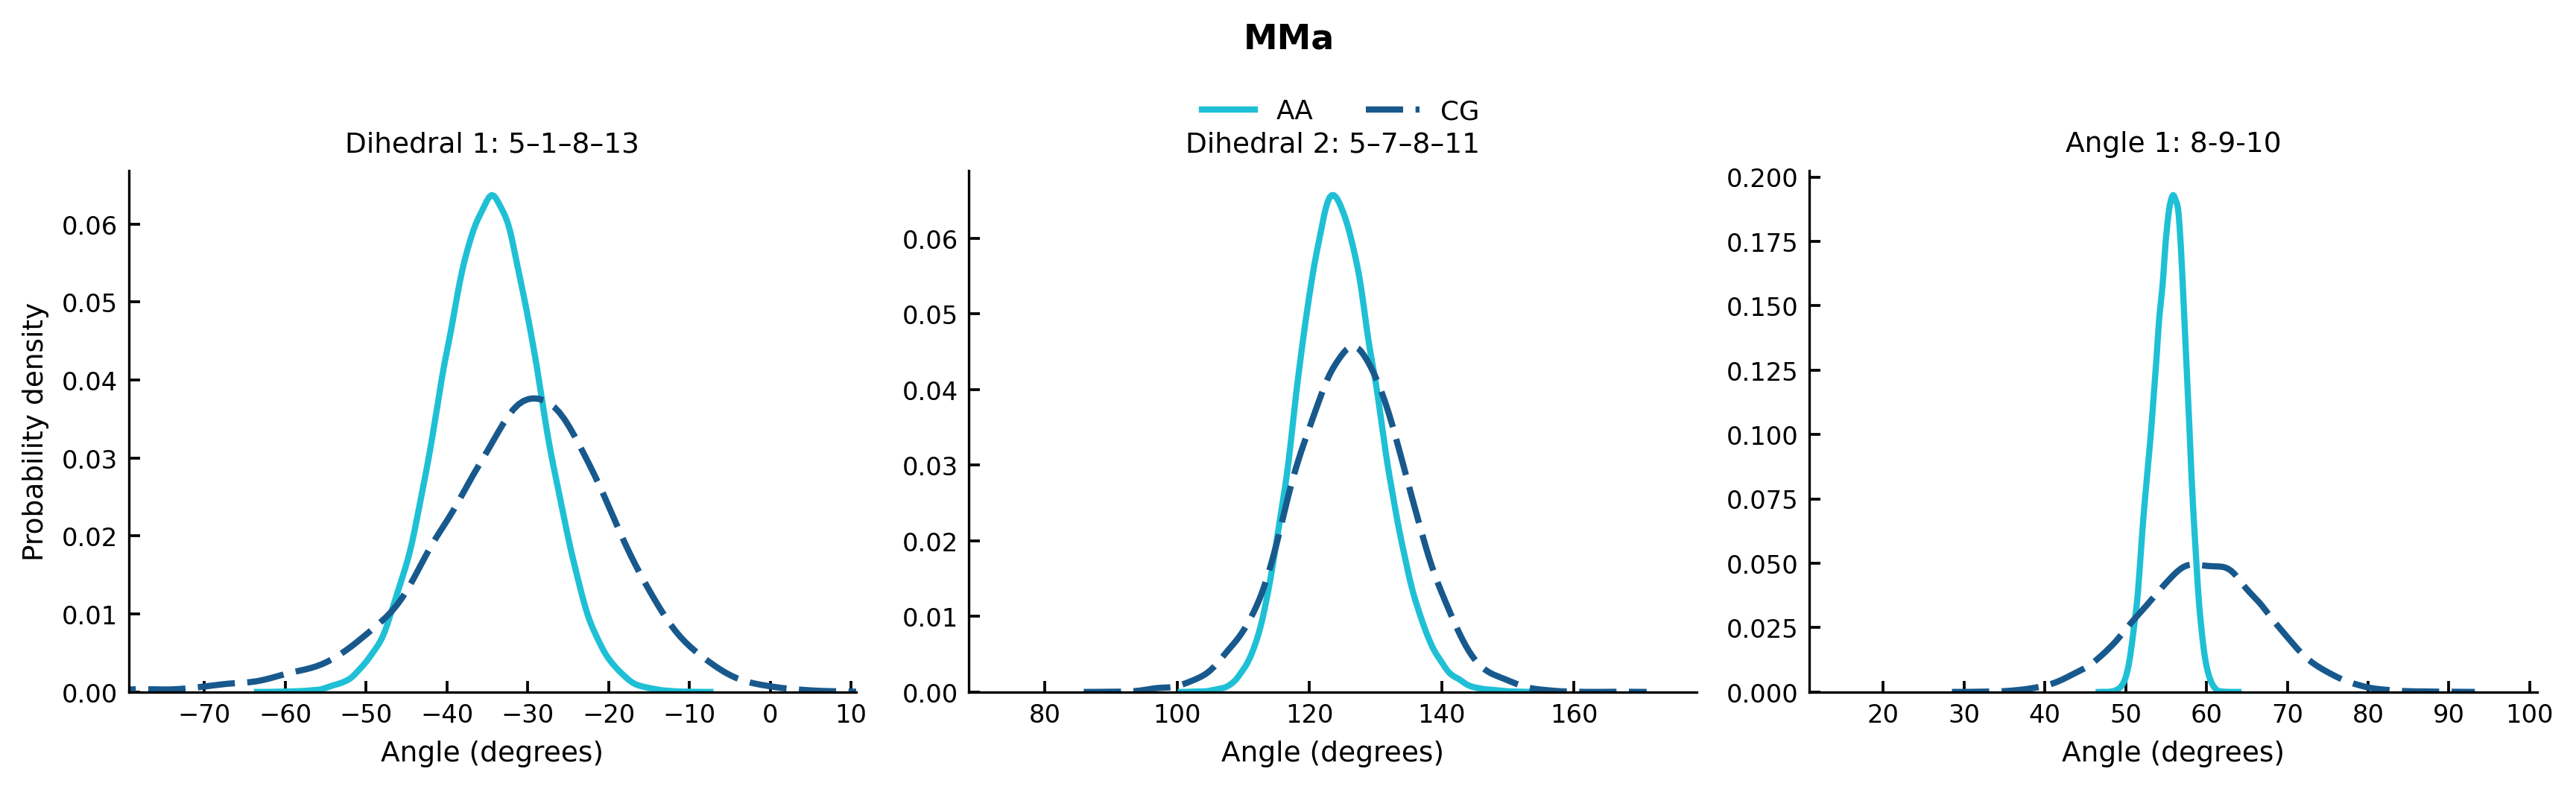

In [85]:
import sys, os
from scipy.stats import gaussian_kde
# --- bring in the styler
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))
from md_styler import MDStyler
sty = MDStyler().apply()

# convenience colors & line styles
c_aa = sty.get_color("cyan")      # AA color
c_cg = sty.get_color("box")       # CG color (deep blue)
kw_aa = sty.as_aa()
kw_cg = sty.as_cg()

def kde_mode_center(x):
    """Return the mode (peak) of a 1D distribution."""
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return 0.0
    kde = gaussian_kde(x, bw_method="scott")
    xs = np.linspace(x.min(), x.max(), 1024)
    ys = kde(xs)
    return xs[np.argmax(ys)]

def kde_plot(ax, data, color, label, linestyle):
    sns.kdeplot(data, ax=ax, color=color, linestyle=linestyle, linewidth=2.0, label=label, bw_method="scott")

# --- load data
fig, ax = plt.subplots(1, 3, figsize=(11.6, 3.4))  # aspect not critical; x-scale will be identical

# Panel 1: Dihedral 1
df = load_file(f"{version}/dihedrals_mapped/dih_3.xvg")
ref = load_file(f"{reference}/dihedrals_mapped/dih_3.xvg")
kde_plot(ax[0], ref.value, color=c_aa, label="AA", linestyle=kw_aa["linestyle"])
kde_plot(ax[0], df.value,  color=c_cg, label="CG", linestyle=kw_cg["linestyle"])
peak = kde_mode_center(ref.value)
ax[0].set_xlim(peak - 45, peak + 45)
ax[0].set_title("Dihedral 1: 5–1–8–13")
ax[0].set_xlabel("Angle (degrees)")
ax[0].set_ylabel("Probability density")

# Panel 2: Dihedral 2
df = load_file(f"{version}/dihedrals_mapped/dih_4.xvg")
ref = load_file(f"{reference}/dihedrals_mapped/dih_4.xvg")
kde_plot(ax[1], ref.value, color=c_aa, label="AA", linestyle=kw_aa["linestyle"])
kde_plot(ax[1], df.value,  color=c_cg, label="CG", linestyle=kw_cg["linestyle"])
peak = kde_mode_center(ref.value)
ax[1].set_xlim(peak - 45-10, peak + 45+10)
ax[1].set_title("Dihedral 2: 5–7–8–11")
ax[1].set_xlabel("Angle (degrees)")
ax[1].set_ylabel(None)

# Panel 3: Angle 1
df = load_file(f"{version}/angles_mapped/ang_0.xvg")
ref = load_file(f"{reference}/angles_mapped/ang_0.xvg")
kde_plot(ax[2], ref.value, color=c_aa, label="AA", linestyle=kw_aa["linestyle"])
kde_plot(ax[2], df.value,  color=c_cg, label="CG", linestyle=kw_cg["linestyle"])
peak = kde_mode_center(ref.value)
ax[2].set_xlim(peak - 45, peak + 45)
ax[2].set_title("Angle 1: 8-9-10")
ax[2].set_xlabel("Angle (degrees)")
ax[2].set_ylabel(None)

# shared legend
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.52, 0.95))
fig.suptitle("MMa", fontsize=11, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
df = load_file(f"{version}/angles_mapped/ang_0.xvg")
ref = load_file(f"{reference}/angles_mapped/ang_0.xvg")
kde_plot(ax[2], ref.value, color=c_aa, label="AA", linestyle=kw_aa["linestyle"])
kde_plot(ax[2], df.value,  color=c_cg, label="CG", linestyle=kw_cg["linestyle"])
peak = kde_mode_center(ref.value)
ax[2].set_xlim(peak - 45, peak + 45)
ax[2].set_title("Angle 1: 8–9–10")
ax[2].set_xlabel("Angle (degrees)")
ax[2].set_ylabel(None)
